In [1]:
import numpy as np
import os, sys 
import random 
import matplotlib.pyplot as plt
import copy
from torchvision.transforms import ToTensor
import torch 
from torch import linalg as LA
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.datasets as datasets
from torch.utils.data import SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mnist_trainset = datasets.MNIST(root='/content/drive/My Drive', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='/content/drive/My Drive', train=False, download=True, transform=ToTensor())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # defining convolution layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.maxpool = nn.MaxPool2d(kernel_size=2)                             
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)         
        # defining fully connected layers
        self.fc1 = nn.Linear(1024, 512)
        # self.dropout = nn.Dropout2d()
        self.fc2 = nn.Linear(512, 10)
        # self.softmax nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        # x = self.dropout(x)
        x = self.maxpool(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        x = F.relu(self.fc1(x))
        # x = F.dropout(x)
        output = self.fc2(x)
        return output    

In [ ]:
def process_messages(queue_i, weights_i, alpha_i, with_noise, alpha_update):
    while len(queue_i) != 0:
        weights_j, alpha_j = queue_i.pop()
        for layer in weights_i.keys():
            if  with_noise == True:
                noise = torch.randn_like(weights_j[layer])
            else:
                noise = 0    
            
            weights_i[layer] = (alpha_j/(alpha_i+alpha_j)) * (weights_j[layer] + 0.1*noise) + (alpha_i/(alpha_i+alpha_j)) * weights_i[layer]
            if alpha_update == True:
                alpha_i += alpha_j

    return weights_i, alpha_i        

In [ ]:
def push_message(queue_j, weights_i, alpha_i):
    queue_j.append([weights_i, alpha_i/2])

In [ ]:
def train(iter_no, worker_num, with_noise=False, alpha_update=True):
    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    new_weights, new_alpha = process_messages(queue, net.state_dict(), alpha, with_noise, alpha_update)
    net.load_state_dict(new_weights)
    nets_list[worker_num] = net
    alpha_list[worker_num] = new_alpha

    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    # dataset_size = len(mnist_trainset)
    # data_indice = [np.random.choice(list(range(dataset_size)))]
    # train_sampler = SubsetRandomSampler(data_indice)
    # train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, shuffle=False, batch_size=batch_size, sampler=train_sampler)
    try :
        batch_data, batch_labels = data_iters[worker_num].next()
    except:
        train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
        data_iters[worker_num] = iter(train_loader)

        batch_data, batch_labels = data_iters[worker_num].next()


    # Transfer to GPU
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    # zero the parameter gradients
    optimizer = optimizers[worker_num]
    optimizer.zero_grad()
    # Model computations
    batch_outputs = net(batch_data)        
    loss = criterion(batch_outputs, batch_labels)
    loss.backward()
    # print statistics
    print('Training: ', 'Iteration No: ', iter_no+1, 'Worker Num: ', worker_num, '\n',
    'Loss: ', loss.item())
    clipping_value = 1 # arbitrary value of your choosing
    torch.nn.utils.clip_grad_norm(net.parameters(), clipping_value)
    optimizer.step()
    train_losses[worker_num].append(loss.item())

    S = np.random.binomial(1, p, 1)
    if S == 1:
        j = np.random.choice(comm_matrix[worker_num])
        push_message(queues_list[j], net.state_dict(), alpha)

    nets_list[worker_num] = net   
    optimizers[worker_num] = optimizer

In [ ]:
def test(iter_no, networks):
    layers = networks[0].state_dict().keys()
    test_weights = {}
    for layer in layers:
        test_weights[layer] = 0
        for network in networks:
            test_weights[layer] += network.state_dict()[layer]

        test_weights[layer] /= num_workers

    test_network.load_state_dict(test_weights)    

    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            # Model computations
            batch_outputs = test_network(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            # compute accuracy
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        test_losses.append(sum(batch_losses) / len(batch_losses))
        print('Test: ', 'Iteration No: ', iter_no+1,'\n',
            'Loss: ', test_losses[-1])
        acc = (counter*100) / total   
        test_accuracy.append(acc)    
        print('Test accuracy: ', acc) 
    if acc >= 96:
        print('96 % accuracy reached!')
        
    return acc

# GOSGD

In [ ]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [ ]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [ ]:
test_network = CNN().to(device)

In [ ]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [ ]:
max_iters = 1000
p = 0.5
batch_size = 128

In [ ]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [ ]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [ ]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [ ]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [ ]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num)
    acc = test(iter_no, nets_list)
    if acc >= 96 :
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.301302671432495
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.3067712783813477
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.306518077850342
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.3070125579833984
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.2927677631378174
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3039631843566895


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  0.39585353368068044
Test accuracy:  88.76
Training:  Iteration No:  90 Worker Num:  0 
 Loss:  0.47639667987823486
Training:  Iteration No:  90 Worker Num:  1 
 Loss:  0.3697565793991089
Training:  Iteration No:  90 Worker Num:  2 
 Loss:  0.5603494644165039
Training:  Iteration No:  90 Worker Num:  3 
 Loss:  0.3840983211994171
Training:  Iteration No:  90 Worker Num:  4 
 Loss:  0.48018163442611694
Training:  Iteration No:  90 Worker Num:  5 
 Loss:  0.42834582924842834
Training:  Iteration No:  90 Worker Num:  6 
 Loss:  0.48394283652305603
Training:  Iteration No:  90 Worker Num:  7 
 Loss:  0.532922089099884
Test:  Iteration No:  90 
 Loss:  0.3857062511806247
Test accuracy:  89.26
Training:  Iteration No:  91 Worker Num:  0 
 Loss:  0.3828847408294678
Training:  Iteration No:  91 Worker Num:  1 
 Loss:  0.336464524269104
Training:  Iteration No:  91 Worker Num:  2 
 Loss:  0.43014800548553467
Training:  Iteration No:  91 

In [ ]:
max(test_accuracy)

96.07

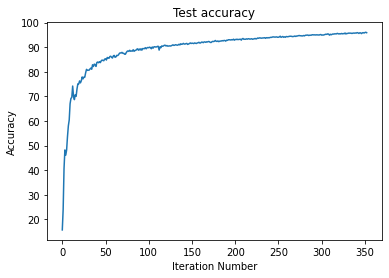

In [ ]:
plt.plot(test_accuracy)
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [ ]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [ ]:
len(test_losses)

353

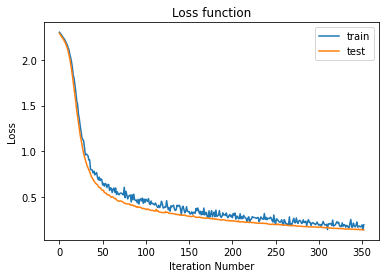

In [ ]:
plt.plot(avg_train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

# Noisy connections

## Noise = 0.01

In [ ]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [ ]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [ ]:
test_network = CNN().to(device)

In [ ]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [ ]:
max_iters = 1000
p = 0.5
batch_size = 128

In [ ]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [ ]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [ ]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [ ]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [ ]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num, with_noise=True)
    acc = test(iter_no, nets_list)
    if acc >= 96:
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.3080592155456543
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.3078372478485107
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.30560040473938
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.3064398765563965
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.2940196990966797
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3083548545837402


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  0.4114264742105822
Test accuracy:  88.62
Training:  Iteration No:  85 Worker Num:  0 
 Loss:  0.5685581564903259
Training:  Iteration No:  85 Worker Num:  1 
 Loss:  0.5412850975990295
Training:  Iteration No:  85 Worker Num:  2 
 Loss:  0.5660219192504883
Training:  Iteration No:  85 Worker Num:  3 
 Loss:  0.5304107069969177
Training:  Iteration No:  85 Worker Num:  4 
 Loss:  0.5256035327911377
Training:  Iteration No:  85 Worker Num:  5 
 Loss:  0.5269055366516113
Training:  Iteration No:  85 Worker Num:  6 
 Loss:  0.6042199730873108
Training:  Iteration No:  85 Worker Num:  7 
 Loss:  0.5524095296859741
Test:  Iteration No:  85 
 Loss:  0.41026012627761577
Test accuracy:  88.72
Training:  Iteration No:  86 Worker Num:  0 
 Loss:  0.589164137840271
Training:  Iteration No:  86 Worker Num:  1 
 Loss:  0.44098833203315735
Training:  Iteration No:  86 Worker Num:  2 
 Loss:  0.5265860557556152
Training:  Iteration No:  86 Wor

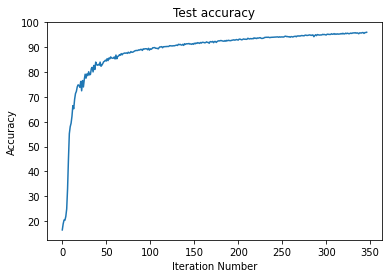

In [ ]:
plt.plot(test_accuracy)
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [ ]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [ ]:
len(test_losses)

347

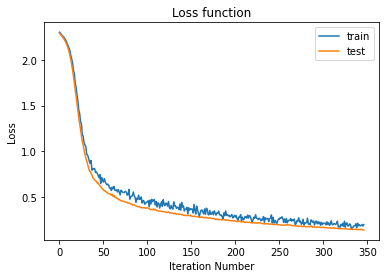

In [ ]:
plt.plot(avg_train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

## Noise = 0.1

In [ ]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [ ]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [ ]:
test_network = CNN().to(device)

In [ ]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [ ]:
max_iters = 1000
p = 0.5
batch_size = 128

In [ ]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [ ]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [ ]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [ ]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [ ]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num, with_noise=True)
    acc = test(iter_no, nets_list)
    if acc >= 96:
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.3095219135284424
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.304172992706299
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.30245304107666
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.310290575027466
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.307863235473633
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3171119689941406


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  3.090336561203003
Training:  Iteration No:  370 Worker Num:  7 
 Loss:  4.733135223388672
Test:  Iteration No:  370 
 Loss:  1.3777252401732192
Test accuracy:  87.0
Training:  Iteration No:  371 Worker Num:  0 
 Loss:  3.164806604385376
Training:  Iteration No:  371 Worker Num:  1 
 Loss:  2.3668408393859863
Training:  Iteration No:  371 Worker Num:  2 
 Loss:  2.112806797027588
Training:  Iteration No:  371 Worker Num:  3 
 Loss:  2.616762638092041
Training:  Iteration No:  371 Worker Num:  4 
 Loss:  3.2156693935394287
Training:  Iteration No:  371 Worker Num:  5 
 Loss:  1.790697693824768
Training:  Iteration No:  371 Worker Num:  6 
 Loss:  3.7608156204223633
Training:  Iteration No:  371 Worker Num:  7 
 Loss:  3.1508169174194336
Test:  Iteration No:  371 
 Loss:  1.4818666618364522
Test accuracy:  86.17
Training:  Iteration No:  372 Worker Num:  0 
 Loss:  2.887624979019165
Training:  Iteration No:  372 Worker Num:  1 
 L

KeyboardInterrupt: ignored

In [ ]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [ ]:
len(test_losses)

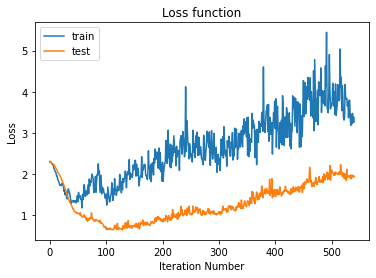

In [ ]:
plt.plot(avg_train_losses[0:-20], label='train')
plt.plot(test_losses[0:-20], label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

# Doubly Stochastic Matrix

In [ ]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [ ]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [ ]:
test_network = CNN().to(device)

In [ ]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [ ]:
max_iters = 1000
p = 0.5
batch_size = 128

In [ ]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [ ]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [ ]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [ ]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [ ]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num, with_noise=False, alpha_update=False)
    acc = test(iter_no, nets_list)
    if acc >= 96:
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.3060126304626465
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.311095952987671
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.306824207305908
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.3151047229766846
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.306621789932251
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3119373321533203


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  0.43747336389143254
Test accuracy:  88.2
Training:  Iteration No:  73 Worker Num:  0 
 Loss:  0.4474974572658539
Training:  Iteration No:  73 Worker Num:  1 
 Loss:  0.4420727789402008
Training:  Iteration No:  73 Worker Num:  2 
 Loss:  0.5361692309379578
Training:  Iteration No:  73 Worker Num:  3 
 Loss:  0.469364732503891
Training:  Iteration No:  73 Worker Num:  4 
 Loss:  0.3839412331581116
Training:  Iteration No:  73 Worker Num:  5 
 Loss:  0.4154209494590759
Training:  Iteration No:  73 Worker Num:  6 
 Loss:  0.5448828935623169
Training:  Iteration No:  73 Worker Num:  7 
 Loss:  0.4542374014854431
Test:  Iteration No:  73 
 Loss:  0.42674975578166263
Test accuracy:  88.62
Training:  Iteration No:  74 Worker Num:  0 
 Loss:  0.6254955530166626
Training:  Iteration No:  74 Worker Num:  1 
 Loss:  0.7226269245147705
Training:  Iteration No:  74 Worker Num:  2 
 Loss:  0.5301005840301514
Training:  Iteration No:  74 Work

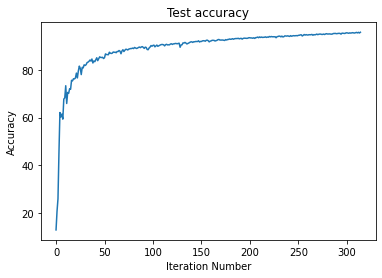

In [ ]:
plt.plot(test_accuracy[0:-20])
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [ ]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [ ]:
len(test_losses)

335

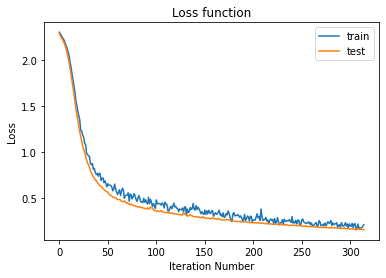

In [ ]:
plt.plot(avg_train_losses[0:-20], label='train')
plt.plot(test_losses[0:-20], label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

#Periodically Connected Communication Matrix

In [6]:
def process_messages(queue_i, weights_i, alpha_i, with_noise, alpha_update):
    while len(queue_i) != 0:
        weights_j, alpha_j = queue_i.pop()
        for layer in weights_i.keys():
            if  with_noise == True:
                noise = torch.randn_like(weights_j[layer])
            else:
                noise = 0    
            
            weights_i[layer] = (alpha_j/(alpha_i+alpha_j)) * (weights_j[layer] + 0.1*noise) + (alpha_i/(alpha_i+alpha_j)) * weights_i[layer]
            if alpha_update == True:
                alpha_i += alpha_j

    return weights_i, alpha_i        

In [7]:
def push_message(queue_j, weights_i, alpha_i):
    queue_j.append([weights_i, alpha_i/2])

In [8]:
def train(iter_no, worker_num, with_noise=False, alpha_update=True):
    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    new_weights, new_alpha = process_messages(queue, net.state_dict(), alpha, with_noise, alpha_update)
    net.load_state_dict(new_weights)
    nets_list[worker_num] = net
    alpha_list[worker_num] = new_alpha

    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    # dataset_size = len(mnist_trainset)
    # data_indice = [np.random.choice(list(range(dataset_size)))]
    # train_sampler = SubsetRandomSampler(data_indice)
    # train_loader = torch.utils.data.DataLoader(dataset=mnist_trainset, shuffle=False, batch_size=batch_size, sampler=train_sampler)
    try :
        batch_data, batch_labels = data_iters[worker_num].next()
    except:
        train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
        data_iters[worker_num] = iter(train_loader)

        batch_data, batch_labels = data_iters[worker_num].next()


    # Transfer to GPU
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    # zero the parameter gradients
    optimizer = optimizers[worker_num]
    optimizer.zero_grad()
    # Model computations
    batch_outputs = net(batch_data)        
    loss = criterion(batch_outputs, batch_labels)
    loss.backward()
    # print statistics
    print('Training: ', 'Iteration No: ', iter_no+1, 'Worker Num: ', worker_num, '\n',
    'Loss: ', loss.item())
    clipping_value = 1 # arbitrary value of your choosing
    torch.nn.utils.clip_grad_norm(net.parameters(), clipping_value)
    optimizer.step()
    train_losses[worker_num].append(loss.item())

    S = np.random.binomial(1, p, 1)
    if S == 1:
        if 1 in comm_matrix[worker_num, :]:
            j = list(comm_matrix[worker_num, :]).index(1)
            push_message(queues_list[j], net.state_dict(), alpha)

    nets_list[worker_num] = net   
    optimizers[worker_num] = optimizer

In [9]:
def test(iter_no, networks):
    layers = networks[0].state_dict().keys()
    test_weights = {}
    for layer in layers:
        test_weights[layer] = 0
        for network in networks:
            test_weights[layer] += network.state_dict()[layer]

        test_weights[layer] /= num_workers

    test_network.load_state_dict(test_weights)    

    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            # Model computations
            batch_outputs = test_network(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            # compute accuracy
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        test_losses.append(sum(batch_losses) / len(batch_losses))
        print('Test: ', 'Iteration No: ', iter_no+1,'\n',
            'Loss: ', test_losses[-1])
        acc = (counter*100) / total   
        test_accuracy.append(acc)    
        print('Test accuracy: ', acc) 
    if acc >= 96:
        print('96 % accuracy reached!')
        
    return acc

In [10]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [11]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [12]:
test_network = CNN().to(device)

In [13]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [14]:
max_iters = 1000
p = 0.5
batch_size = 128

In [15]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [16]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [17]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [18]:
comm_matrices = []
for i in range (num_workers-1):
    mat = torch.zeros(num_workers, num_workers)
    mat[i, i+1] = 1
    mat[i+1, i] = 1
    comm_matrices.append(mat)

In [19]:
ss = 0
for iter_no in range(max_iters):
    comm_matrix = comm_matrices[ss]
    for worker_num in range(num_workers):
        train(iter_no, worker_num, with_noise=False, alpha_update=False)
    acc = test(iter_no, nets_list)
    if acc >= 96:
        break

    if ss != 6:
        ss += 1
    else:
        ss = 0        



    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.309110641479492
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.3120899200439453
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.3102314472198486
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.301419734954834
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.3046247959136963
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3101987838745117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  0.3769218490659436
Test accuracy:  89.18
Training:  Iteration No:  104 Worker Num:  0 
 Loss:  0.4727098345756531
Training:  Iteration No:  104 Worker Num:  1 
 Loss:  0.46219903230667114
Training:  Iteration No:  104 Worker Num:  2 
 Loss:  0.5160382986068726
Training:  Iteration No:  104 Worker Num:  3 
 Loss:  0.5101471543312073
Training:  Iteration No:  104 Worker Num:  4 
 Loss:  0.3392745852470398
Training:  Iteration No:  104 Worker Num:  5 
 Loss:  0.4318375885486603
Training:  Iteration No:  104 Worker Num:  6 
 Loss:  0.43993106484413147
Training:  Iteration No:  104 Worker Num:  7 
 Loss:  0.37398970127105713
Test:  Iteration No:  104 
 Loss:  0.3725698050818866
Test accuracy:  89.32
Training:  Iteration No:  105 Worker Num:  0 
 Loss:  0.40500199794769287
Training:  Iteration No:  105 Worker Num:  1 
 Loss:  0.4650942087173462
Training:  Iteration No:  105 Worker Num:  2 
 Loss:  0.46468856930732727
Training:  Itera

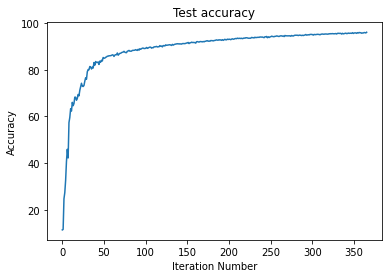

In [20]:
plt.plot(test_accuracy)
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [21]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [22]:
len(test_losses)

366

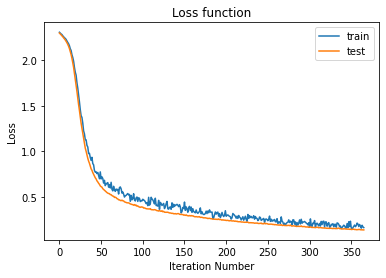

In [23]:
plt.plot(avg_train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

# Distributed Data Optimization

In [126]:
num_users = 8

s = len(mnist_trainset)
client_data_sizes = []
for i in range(num_users-1):
    # l = random.randrange(1000, 4000)
    l = len(mnist_trainset) // num_users
    client_data_sizes.append(l)
    s -= l

client_data_sizes.append(len(mnist_trainset) - sum(client_data_sizes))
 
distributed_train_data = random_split(mnist_trainset, client_data_sizes)

In [128]:
batch_size = 128
train_loaders = []
for i in range(num_users):
    train_loaders.append(torch.utils.data.DataLoader(
                 dataset=distributed_train_data[i],
                 batch_size=batch_size,
                 shuffle=True
                 ))

In [129]:
def process_messages(queue_i, weights_i, alpha_i, with_noise, alpha_update):
    while len(queue_i) != 0:
        weights_j, alpha_j = queue_i.pop()
        for layer in weights_i.keys():
            if  with_noise == True:
                noise = torch.randn_like(weights_j[layer])
            else:
                noise = 0    
            
            weights_i[layer] = (alpha_j/(alpha_i+alpha_j)) * (weights_j[layer] + 0.1*noise) + (alpha_i/(alpha_i+alpha_j)) * weights_i[layer]
            if alpha_update == True:
                alpha_i += alpha_j

    return weights_i, alpha_i        

In [130]:
def push_message(queue_j, weights_i, alpha_i):
    queue_j.append([weights_i, alpha_i/2])

In [131]:
def train(iter_no, worker_num, with_noise=False, alpha_update=True):
    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    new_weights, new_alpha = process_messages(queue, net.state_dict(), alpha, with_noise, alpha_update)
    net.load_state_dict(new_weights)
    nets_list[worker_num] = net
    alpha_list[worker_num] = new_alpha

    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    alpha = alpha_list[worker_num]

    loss_batch = 0
    for batch_data, batch_labels in train_loaders[worker_num]:
        # Transfer to GPU
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        # zero the parameter gradients
        optimizer = optimizers[worker_num]
        optimizer.zero_grad()
        # Model computations
        batch_outputs = net(batch_data)        
        loss = criterion(batch_outputs, batch_labels)
        loss.backward()
        loss_batch += loss.item()
        # print statistics
        
        clipping_value = 1 # arbitrary value of your choosing
        torch.nn.utils.clip_grad_norm(net.parameters(), clipping_value)
        optimizer.step()

    train_losses[worker_num].append(loss_batch / len(train_loaders[worker_num]))
    print('Training: ', 'Iteration No: ', iter_no+1, 'Worker Num: ', worker_num, '\n',
        'Loss: ', train_losses[worker_num][-1])

    S = np.random.binomial(1, p, 1)
    if S == 1:
        j = np.random.choice(comm_matrix[worker_num])
        push_message(queues_list[j], net.state_dict(), alpha)

    nets_list[worker_num] = net   
    optimizers[worker_num] = optimizer

In [132]:
def test(iter_no, networks):
    layers = networks[0].state_dict().keys()
    test_weights = {}
    for layer in layers:
        test_weights[layer] = 0
        for network in networks:
            test_weights[layer] += network.state_dict()[layer]

        test_weights[layer] /= num_workers

    test_network.load_state_dict(test_weights)    

    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            # Model computations
            batch_outputs = test_network(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            # compute accuracy
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        test_losses.append(sum(batch_losses) / len(batch_losses))
        print('Test: ', 'Iteration No: ', iter_no+1,'\n',
            'Loss: ', test_losses[-1])
        acc = (counter*100) / total   
        test_accuracy.append(acc)    
        print('Test accuracy: ', acc) 
    if acc >= 99:
        print('96 % accuracy reached!')
        
    return acc

In [133]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [134]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [135]:
test_network = CNN().to(device)

In [136]:
queues_list = [[] for i in range (num_workers)]
alpha_list = [1 / num_workers for i in range (num_workers)]

In [137]:
max_iters = 1000
p = 0.5
batch_size = 128

In [138]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [139]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [140]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [141]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num, alpha_update=False)
    acc = test(iter_no, nets_list)
    if acc >= 99:
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Training:  Iteration No:  1 Worker Num:  0 
 Loss:  1.3886847546545125
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  1.3618089566796512
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  1.3524300506559468
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  1.3463359656980483
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  1.3765747213767747
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  0.8391237789291447
Training:  Iteration No:  1 Worker Num:  6 
 Loss:  1.368616917375791
Training:  Iteration No:  1 Worker Num:  7 
 Loss:  0.8576579881926715
Test:  Iteration No:  1 
 Loss:  0.5208080661824986
Test accuracy:  86.16
Training:  Iteration No:  2 Worker Num:  0 
 Loss:  0.47590430055634453
Training:  Iteration No:  2 Worker Num:  1 
 Loss:  0.5036695806656853
Training:  Iteration No:  2 Worker Num:  2 
 Loss:  0.5019807648860802
Training:  Iteration No:  2 Worker Num:  3 
 Loss:  0.5105557840759471
Training:  Iteration No:  2 Worker Num:  4 
 Loss:  0.4982825022632793
Tra

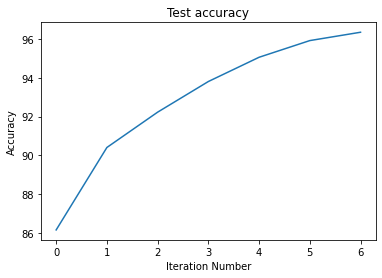

In [142]:
plt.plot(test_accuracy)
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [144]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [145]:
len(test_losses)

7

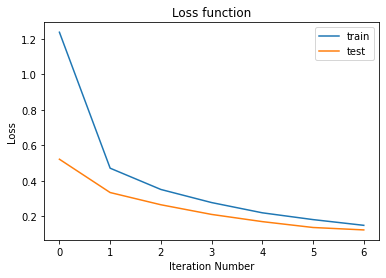

In [150]:
plt.plot(avg_train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');

# Stochastic Matrix

In [107]:
def process_messages(i, queue_i, weights_i, with_noise, alpha_update):
    while len(queue_i) != 0:
        j, weights_j, alpha_j_i = queue_i.pop()
        alpha_i_j = alpha_matrix[i,j]
        for layer in weights_i.keys():
            if  with_noise == True:
                noise = torch.randn_like(weights_j[layer])
            else:
                noise = 0    
            
            weights_i[layer] = (alpha_j_i/(alpha_i_j+alpha_j_i)) * (weights_j[layer] + 0.1*noise) + (alpha_i_j/(alpha_i_j+alpha_j_i)) * weights_i[layer]
            if alpha_update == True:
                alpha_i_j += alpha_j_i

    return weights_i     

In [108]:
def push_message(i, j, queue_j, weights_i):
    queue_j.append([i, weights_i, alpha_matrix[i,j]/2])

In [109]:
def train(iter_no, worker_num, with_noise=False, alpha_update=True):
    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    # alpha = alpha_list[worker_num]

    new_weights = process_messages(worker_num, queue, net.state_dict(), with_noise, alpha_update)
    net.load_state_dict(new_weights)
    nets_list[worker_num] = net
    # alpha_list[worker_num] = new_alpha

    net = nets_list[worker_num]
    queue = queues_list[worker_num]
    # alpha = alpha_list[worker_num]

    
    try :
        batch_data, batch_labels = data_iters[worker_num].next()
    except:
        train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
        data_iters[worker_num] = iter(train_loader)

        batch_data, batch_labels = data_iters[worker_num].next()


    # Transfer to GPU
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    # zero the parameter gradients
    optimizer = optimizers[worker_num]
    optimizer.zero_grad()
    # Model computations
    batch_outputs = net(batch_data)        
    loss = criterion(batch_outputs, batch_labels)
    loss.backward()
    # print statistics
    print('Training: ', 'Iteration No: ', iter_no+1, 'Worker Num: ', worker_num, '\n',
    'Loss: ', loss.item())
    clipping_value = 1 # arbitrary value of your choosing
    torch.nn.utils.clip_grad_norm(net.parameters(), clipping_value)
    optimizer.step()
    train_losses[worker_num].append(loss.item())

    S = np.random.binomial(1, p, 1)
    if S == 1:
        j = np.random.choice(comm_matrix[worker_num])
        push_message(j, worker_num, queues_list[j], net.state_dict())

    nets_list[worker_num] = net   
    optimizers[worker_num] = optimizer

In [110]:
def test(iter_no, networks):
    layers = networks[0].state_dict().keys()
    test_weights = {}
    for layer in layers:
        test_weights[layer] = 0
        for network in networks:
            test_weights[layer] += network.state_dict()[layer]

        test_weights[layer] /= num_workers

    test_network.load_state_dict(test_weights)    

    # Validation
    with torch.set_grad_enabled(False):
        batch_losses = []
        counter = 0
        total = 0
        for batch_data, batch_labels in test_loader:
            total += len(batch_data)
            # Transfer to GPU
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            # Model computations
            batch_outputs = test_network(batch_data)            
            loss = criterion(batch_outputs, batch_labels)
            batch_losses.append(loss.item())
            
            # compute accuracy
            for i in range(len(batch_data)):
                true = int(batch_labels[i])
                pred = int(torch.argmax(batch_outputs[i,:]))
                if pred == true:
                    counter += 1

        test_losses.append(sum(batch_losses) / len(batch_losses))
        print('Test: ', 'Iteration No: ', iter_no+1,'\n',
            'Loss: ', test_losses[-1])
        acc = (counter*100) / total   
        test_accuracy.append(acc)    
        print('Test accuracy: ', acc) 
    if acc >= 96:
        print('96 % accuracy reached!')
        
    return acc

In [111]:
num_workers = 8
all_workers = [i for i in range (num_workers)]

In [112]:
alpha_matrix = F.normalize(torch.rand(num_workers, num_workers))

In [113]:
nets_list = [CNN().to(device)]
optimizers = [optim.SGD(nets_list[0].parameters(), lr = 0.1)]
# schedulers = [optim.lr_scheduler.MultiStepLR(optimizers[0], milestones=[210], gamma=0.1)]
for i in range(1,num_workers):
    new_net = CNN().to(device)
    new_net.load_state_dict(nets_list[0].state_dict())
    nets_list.append(new_net)
    optimizer = optim.SGD(new_net.parameters(), lr = 0.1) 
    optimizers.append(optimizer)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[210], gamma=0.1)
    # schedulers.append(scheduler)

In [114]:
test_network = CNN().to(device)

In [115]:
queues_list = [[] for i in range (num_workers)]
# alpha_list = [1 / num_workers for i in range (num_workers)]

In [116]:
max_iters = 1000
p = 0.5
batch_size = 128

In [117]:
data_iters = []
for i in range(num_workers):
    train_loader = torch.utils.data.DataLoader(
                 dataset=mnist_trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )
    
    data_iters.append(iter(train_loader))

In [118]:
test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle=False
                )

In [119]:
criterion = nn.CrossEntropyLoss()
train_losses = [[] for i in range (num_workers)]
test_losses = []
test_accuracy = []

In [120]:
comm_matrix = []
for i in range (num_workers):
    adj_nodes = list(range(num_workers))
    del adj_nodes[i]
    comm_matrix.append(adj_nodes)

In [121]:
for iter_no in range(max_iters):
    for worker_num in range(num_workers):
        train(iter_no, worker_num, alpha_update=False)
    acc = test(iter_no, nets_list)
    if acc >= 96:
        break

    # for scheduler in schedulers:
    #     scheduler.step()    

Training:  Iteration No:  1 Worker Num:  0 
 Loss:  2.3137171268463135
Training:  Iteration No:  1 Worker Num:  1 
 Loss:  2.308102607727051
Training:  Iteration No:  1 Worker Num:  2 
 Loss:  2.3135571479797363
Training:  Iteration No:  1 Worker Num:  3 
 Loss:  2.3140082359313965
Training:  Iteration No:  1 Worker Num:  4 
 Loss:  2.310858726501465
Training:  Iteration No:  1 Worker Num:  5 
 Loss:  2.3074374198913574
Training:  Iteration No:  1 Worker Num:  6 
 Loss:  2.313650369644165


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Streaming output truncated to the last 5000 lines.
 Loss:  0.44192833915541446
Test accuracy:  87.66
Training:  Iteration No:  76 Worker Num:  0 
 Loss:  0.5950531959533691
Training:  Iteration No:  76 Worker Num:  1 
 Loss:  0.4464334547519684
Training:  Iteration No:  76 Worker Num:  2 
 Loss:  0.4745464026927948
Training:  Iteration No:  76 Worker Num:  3 
 Loss:  0.45453640818595886
Training:  Iteration No:  76 Worker Num:  4 
 Loss:  0.5553104281425476
Training:  Iteration No:  76 Worker Num:  5 
 Loss:  0.4745117723941803
Training:  Iteration No:  76 Worker Num:  6 
 Loss:  0.4318024516105652
Training:  Iteration No:  76 Worker Num:  7 
 Loss:  0.5118237137794495
Test:  Iteration No:  76 
 Loss:  0.43326282142838346
Test accuracy:  88.01
Training:  Iteration No:  77 Worker Num:  0 
 Loss:  0.5170127153396606
Training:  Iteration No:  77 Worker Num:  1 
 Loss:  0.5205230712890625
Training:  Iteration No:  77 Worker Num:  2 
 Loss:  0.6030197143554688
Training:  Iteration No:  77 W

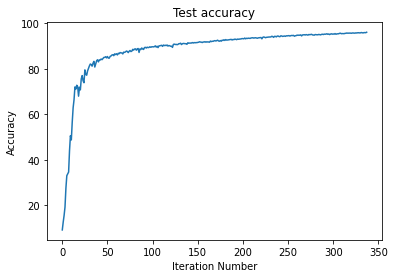

In [122]:
plt.plot(test_accuracy)
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.title('Test accuracy');

In [123]:
avg_train_losses = []
for i in range(len(train_losses[0])):
    avg_loss = 0
    for j in range(num_workers):
        avg_loss += train_losses[j][i]

    avg_train_losses.append(avg_loss / num_workers)    


In [124]:
len(test_losses)

338

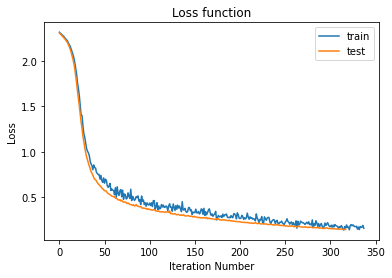

In [125]:
plt.plot(avg_train_losses, label='train')
plt.plot(test_losses[0:-20], label='test')
plt.xlabel('Iteration Number')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss function');